# Tutorial for the ESPClust package

This is a tutorial showing how to use functions from the ESPClust library. 

The association between 94 polar metabolites and insuline resistance of non-diabetic individuals is used as an example. The covariates considered as potential effect size profile modifiers are the BMI, sex and gut microbiome gene richness. 

Load required libraries:

In [3]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as smapi

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

import ESPClust as ESPClust

# for creating a responsive plot
#%matplotlib widget
##pip install ipympl

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Data preparation

Read data for the key quantities used in the ESPClust method:
* Exposures, $\{X_1,X_2,\dots,X_M\}$. In this example, these are a set of $M=94$ metabolites stored below in a dataframe called `exposures`.
* Outcome $Y$. Here, the outcome is insulin resistance which is stored in the dataframe `outcome`.
* Covariates, $\{Z_1,Z_2,\dots,Z_M\}$. Here, BMI, sex and gene richness will be used. These are stored below in the dataframe `otherVariables`.

In addition, we read a file with names for the exposures which are useful for result interpretation. This is stored in the `annotation` dataframe.


In [6]:
# Specify the data of the files
outcomefile = "outcomeFile_Pedersen_NonDiabetic.csv" # File with outcome for each individual - Insulin resistance
exposuresfile = "Metabolites_Pedersen_NonDiabetic_known.csv" # Missing were zero in the original dataset - Transformed to true missing values (blanks)
annotationfile = "Annotation_metabolites_Pedersen_NonDiabetic_known.csv"
otherVariablesFile = "OtherVariables_Pedersen_NonDiabetic.csv"#"OtherVariables_Prepandemic_Nightingale_NewJul2022.csv"

# Files are read once the names have been specified
outcome = pd.read_csv("Data/" + outcomefile)
annotation = pd.read_csv("Data/" + annotationfile)
exposures = pd.read_csv("Data/" +  exposuresfile)
otherVariables = pd.read_csv("Data/" +  otherVariablesFile)


In [7]:
outcome

,iid,label
0,idv001,3.0
1,idv002,2.6
2,idv003,0.7
3,idv004,1.4
4,idv006,2.1
...,...,...
286,idv393,0.9
287,idv394,0.9
288,idv395,0.6
289,idv396,6.8


### Data preliminary manipulation and cleaning

1. We set simpler names for the columns of the `otherVariables` dataframe. Here, `IR` stands for insulin resistance:

In [10]:
otherVariables.columns = ['StudyNumber','IR','BMI','Gene richness','Diabetes','sex']

In [11]:
otherVariables

,StudyNumber,IR,BMI,Gene richness,Diabetes,sex
0,idv001,3.0,39.1,679861.0,nonDiabetic,M
1,idv002,2.6,29.2,852354.0,nonDiabetic,M
2,idv003,0.7,24.0,983147.0,nonDiabetic,F
3,idv004,1.4,22.1,856417.0,nonDiabetic,F
4,idv006,2.1,32.1,586289.0,nonDiabetic,F
...,...,...,...,...,...,...
286,idv393,0.9,31.1,790764.0,nonDiabetic,F
287,idv394,0.9,28.2,950676.0,nonDiabetic,F
288,idv395,0.6,22.0,671107.0,nonDiabetic,M
289,idv396,6.8,36.1,795826.0,nonDiabetic,F


2. We drop individuals for whom there is no information on insulin resistance:

In [13]:
complete = ~otherVariables['IR'].isnull() # List of positions with complete IR
otherVariables = otherVariables[complete]
exposures = exposures[complete]
outcome = outcome[complete]

3. We encode the sex variable as an integer: Male -> 0, Female -> 1

In [15]:
otherVariables['sex'] = otherVariables['sex'].map({'M':0 , 'F':1})

4. Exposures transformation and cleaning:
- Metabolites whose concentration was missing for more than 20% of individuals are discarded. 
- Individuals who missed more than 20% of the metabolites are also discarded. 
- The remaining missing values for metabolites were imputed using k Nearest Neighbours with k=3.

In addition, exposures are transformed by adding 1 and taking the natural logarithm.

This is achieved through the ESPClust function `data_cleaning`.

Missing metabolites: 2


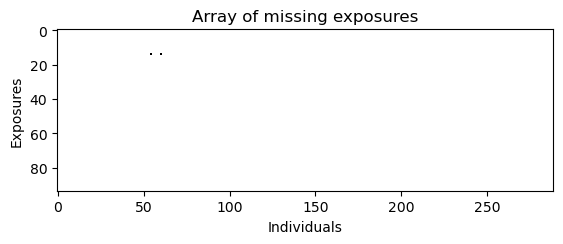

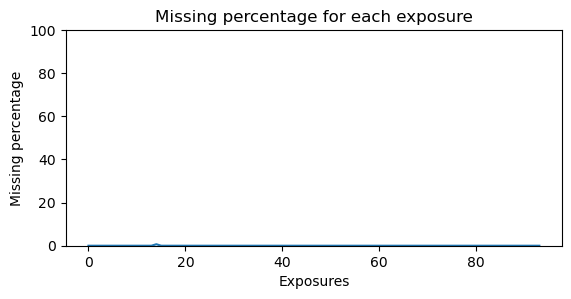

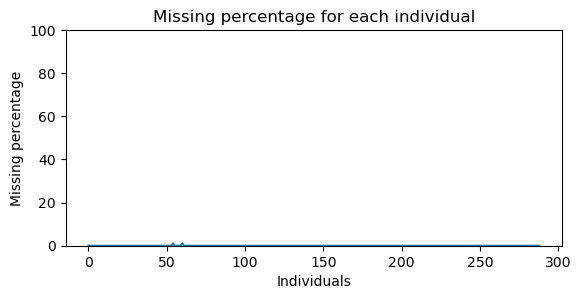

In [17]:
## - Data cleaning
featuresIn = exposures
Yin = outcome
thmissing = 0.2  # exposures that are missing for a proportion larger than this are dropped
k_neighbours = 3 # Value of k for kNN imputation
featTransform = "Plus1Log"
plotYN = 'y'

featuresExtended, exposure_names = ESPClust.data_cleaning(featuresIn,Yin,otherVariables,annotation,thmissing,k_neighbours,featTransform,plotYN)

The function `data_cleaning` provides the following:

- `featuresExtended`: a dataframe with cleaned exposures together with columns from the `otherVariables` dataset and the `outcome` variable.
- `exposure_names`: Names of the exposures that were kept after cleaning. 

In [19]:
featuresExtended.columns

Index(['M_6_2.4.Dihydroxybutanoic.acid.', 'M_27_2.Hydroxybutyric.acid',
       'M_22_3.4.Dihydroxybutanoic.acid', 'M_25_3.Hydroxybutyric.acid',
       'M_28_Alanine', 'M_30_Arachidonic.acid', 'M_8_Aspartic.acid',
       'M_19_Cholesterol', 'M_9_Citric.acid', 'M_2_Glutamic.acid..3TMS',
       ...
       'M_250_alpha.Hydroxyvaleric.acid', 'M_43_beta.D.Galactofuranose',
       'M_298_beta.Hydroxyisovaleric.acid', 'outcome', 'StudyNumber', 'IR',
       'BMI', 'Gene richness', 'Diabetes', 'sex'],
      dtype='object', length=101)

In [20]:
exposure_names

Index(['M_6_2.4.Dihydroxybutanoic.acid.', 'M_27_2.Hydroxybutyric.acid',
       'M_22_3.4.Dihydroxybutanoic.acid', 'M_25_3.Hydroxybutyric.acid',
       'M_28_Alanine', 'M_30_Arachidonic.acid', 'M_8_Aspartic.acid',
       'M_19_Cholesterol', 'M_9_Citric.acid', 'M_2_Glutamic.acid..3TMS',
       'M_21_Glyceric.acid', 'M_10_Glycine', 'M_26_Isoleucine', 'M_23_Leucine',
       'M_14_Linoleic.acid', 'M_4_Methionine', 'M_13_Oleic.acid',
       'M_1_Ornithine', 'M_11_Palmitic.acid', 'M_3_Phenylalanine',
       'M_12_Proline', 'M_24_Serine', 'M_17_Stearic.acid', 'M_5_Threonine',
       'M_16_Tyrosine', 'M_20_Valine', 'M_212_11.Eicosenoic.acid',
       'M_162_1H.Indole.3.acetic.acid', 'M_313_1.Monooleoylglycerol',
       'M_54_1.Octadecanol', 'M_1030_2.3.Dihydroxybutanoic.acid',
       'M_165_2.aminobutyric.acid', 'M_5856_2.Butenedioic.acid',
       'M_127_2.Ethyl.3.hydroxypropionic.acid', 'M_210_2.Oxoisovaleric.acid',
       'M_220_3.4.5.Trihydroxypentanoic.acid',
       'M_63_4..1.1.3.3..tetrame

## ESPClust for on possible effect size profile modifiers

This section applies ESPClust to study BMI as a potential modifier for the effect size profile corresponding to the association of the metabolites and insulin resistance.

### Defining the necessary variables for ESPClust

We first need to set the basic information needed by ESPClust in terms of exposures, outcome and covariates used as confounders and effect size mofifiers:

In [23]:
data = featuresExtended  # Data containing the exposures, the outcome and the covariates
X_name = exposure_names  # Name of the exposures after cleaning
Y_name = "outcome" # Name of the outcome in the data 
modifier_names = ['BMI']  # List of covariates to be considered as potential ESP modifiers
confound_names = ['BMI','sex','Gene richness']  # List of covariates that act as confounders. Their confounding effect will be adjusted within each window of the cover.

### Creating a cover for the covariate space with windows of homogeneous size

We will cover the one-dimensional covariate space with a set of 1D-windows of length `L` obtained by gliding a segment at steps of size `Delta`. For a generic covariate $z$, the cover is following set of intervals: 

$\{ [z_{\min}, z_{\min}+L), [z_{\min}+Delta, z_{\min}+Delta+L), [z_{\min}+2Delta, z_{\min}+2Delta+L) \dots\}$, 

where $z_{\min}$ is the minimum value of the $z$ covariate in the dataset.

This can be implemented with the ESPClust function `Homogeneous_Windows`.

In [25]:
L_in = [8]  # A list of window lengths for each effect size modifier considered
Delta_in = [1]  # A list of the steps used to glide the window in the direction of each effect size modifier

z0,Lw = ESPClust.Homogeneous_Windows(data,modifier_names,L_in,Delta_in)

The function `Homogeneous_Windows` provides two outputs:
- `z0`: List of coordinates of the origin of each window, $\{ z_{min}, z_{min}+Delta, z_{min}+2Delta, \dots\}$. 
- `Lw`: List of dimensions of each window, $\{L,L,L,\dots\}$.

In [27]:
z0

[[18.1,
  19.1,
  20.1,
  21.1,
  22.1,
  23.1,
  24.1,
  25.1,
  26.1,
  27.1,
  28.1,
  29.1,
  30.1,
  31.1,
  32.1,
  33.1,
  34.1,
  35.1,
  36.1,
  37.1,
  38.1,
  39.1,
  40.1,
  41.1,
  42.1,
  43.1,
  44.1,
  45.1,
  46.1]]

In [28]:
Lw

[[8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8]]

### Calculation of the ESP within windows

We use the ESPClust function `effect_windows1_lin` estimate an effect size, $e_m$, for each exposure-outcome pair, $(X_m,Y)$, using linear regression. 


In [30]:
nmin = 10  # Minimum number of observations required to calculate the effect size.

esp_df = ESPClust.effect_windows1_lin(data,X_name,Y_name,confound_names,modifier_names,z0,Lw,nmin)

Variable 1 of 94, M_6_2.4.Dihydroxybutanoic.acid.
Variable 2 of 94, M_27_2.Hydroxybutyric.acid
Variable 3 of 94, M_22_3.4.Dihydroxybutanoic.acid
Variable 4 of 94, M_25_3.Hydroxybutyric.acid
Variable 5 of 94, M_28_Alanine
Variable 6 of 94, M_30_Arachidonic.acid
Variable 7 of 94, M_8_Aspartic.acid
Variable 8 of 94, M_19_Cholesterol
Variable 9 of 94, M_9_Citric.acid
Variable 10 of 94, M_2_Glutamic.acid..3TMS
Variable 11 of 94, M_21_Glyceric.acid
Variable 12 of 94, M_10_Glycine
Variable 13 of 94, M_26_Isoleucine
Variable 14 of 94, M_23_Leucine
Variable 15 of 94, M_14_Linoleic.acid
Variable 16 of 94, M_4_Methionine
Variable 17 of 94, M_13_Oleic.acid
Variable 18 of 94, M_1_Ornithine
Variable 19 of 94, M_11_Palmitic.acid
Variable 20 of 94, M_3_Phenylalanine
Variable 21 of 94, M_12_Proline
Variable 22 of 94, M_24_Serine
Variable 23 of 94, M_17_Stearic.acid
Variable 24 of 94, M_5_Threonine
Variable 25 of 94, M_16_Tyrosine
Variable 26 of 94, M_20_Valine
Variable 27 of 94, M_212_11.Eicosenoic.aci

The funtion `effect_windows1_lin` provides the following dataframe:

`esp_df`: A dataframe with a row for each window of the cover used to sample the covariate space. For a given window, the datagrame gives the following columns:
* `nobs`: Number of observations within the window.
* `BMI_z0`: Origin of the window.
* `BMI_Lw`: Length of the window.
* $M$ columns giving the effect sizes $\{e_m\}_{m=1}^M$ within the window for each metabolite.


In [32]:
esp_df

,nobs,BMI_z0,BMI_Lw,M_6_2.4.Dihydroxybutanoic.acid.,M_27_2.Hydroxybutyric.acid,M_22_3.4.Dihydroxybutanoic.acid,M_25_3.Hydroxybutyric.acid,M_28_Alanine,M_30_Arachidonic.acid,M_8_Aspartic.acid,...,M_191_Pyruvic.acid,M_65_Ribonic.acid,M_932_Ribonic.acid,M_123_Tryptophan,M_71_Tyrosine,M_1035_Urea,M_938_Xylitol,M_250_alpha.Hydroxyvaleric.acid,M_43_beta.D.Galactofuranose,M_298_beta.Hydroxyisovaleric.acid
0,99,18.1,8,0.055357,0.070763,0.085584,-0.023524,0.169904,0.007169,0.026026,...,0.092323,0.098843,0.068151,0.050558,0.009945,0.077701,0.016769,0.030241,-0.046735,0.049064
1,96,19.1,8,0.053728,0.067303,0.083916,-0.031315,0.176932,0.007808,0.041095,...,0.096121,0.091373,0.070324,0.043090,0.002343,0.088563,0.018152,0.033944,-0.047394,0.042380
2,93,20.1,8,0.057477,0.081761,0.098785,-0.018372,0.205272,0.003265,0.048592,...,0.106391,0.085682,0.056203,0.030437,-0.023112,0.090757,0.010170,0.011064,-0.036829,0.032468
3,92,21.1,8,0.054820,0.097338,0.149687,-0.000713,0.239001,0.039469,0.145938,...,0.140255,0.085299,0.093120,0.126373,0.050987,0.113088,0.044438,0.049606,-0.005580,0.071136
4,87,22.1,8,0.038999,0.090234,0.121807,-0.049133,0.272022,0.028322,0.155334,...,0.102173,0.100158,0.100142,0.169451,0.036790,0.109646,0.038054,0.036396,-0.035091,0.101945
5,93,23.1,8,0.046173,0.146475,0.136229,-0.052501,0.285460,0.082917,0.199423,...,0.076211,0.086173,0.049979,0.145478,0.111018,0.142480,0.079850,0.098827,-0.043907,0.083911
6,97,24.1,8,0.089602,0.250772,0.269156,-0.020015,0.396402,0.225449,0.211098,...,0.108990,0.079262,0.033715,0.086582,0.141391,0.208520,-0.029749,0.059141,0.127399,-0.041747
7,105,25.1,8,0.055384,0.240638,0.205558,0.002712,0.364579,0.268987,0.279437,...,0.111571,0.040899,-0.015273,0.090650,0.141625,0.187739,0.056375,0.109198,0.125177,-0.008550
8,113,26.1,8,0.058140,0.208331,0.186662,-0.003658,0.367604,0.223192,0.339297,...,0.202774,-0.036857,0.043366,0.090129,0.167867,0.104940,0.044723,0.204661,0.072969,-0.016951
9,126,27.1,8,0.108271,0.305267,0.262530,0.081983,0.415956,0.202747,0.312082,...,0.252483,0.020902,0.075744,0.115773,0.255977,0.041512,0.076662,0.208354,0.086059,0.095432


It may be convenient to store the dataframe `esp_df` to be used in the future without the need to run the function `effect_windows1_lin`:

In [34]:
esp_df.to_csv('Results/EPS_IR_Metabolites_Modifiers_BMI_n10_LBMI_8_DeltaBMI_1.csv')

**Reading previously calculated effect sizes:**

In [36]:
# - Read the data

esp_df = pd.read_csv('Results/EPS_IR_Metabolites_Modifiers_BMI_n10_LBMI_8_DeltaBMI_1.csv')

### Visualisation of the windows effect size

The dependence of the effect size of the association between an exposure (`variable`) and the outcome as a function of a covariate (`modifier`) can be plotted with the function `Eff_size_Windows_plot` 

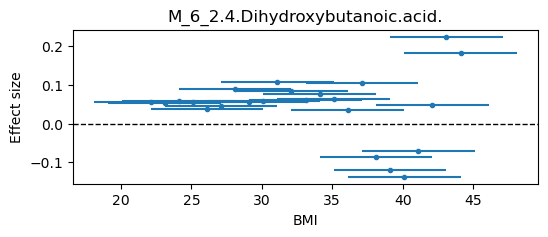

In [38]:
variable = X_name[0]
modifier = "BMI"
no_effect_value = 0
errorbar = 'y'
ESPClust.Eff_size_Windows_plot(esp_df,variable,modifier,no_effect_value,errorbar)

### Clustering of windows according to their ESP

ESPClust provides several functions to analyse the clustering of windows

#### Clustering indices

The function `Clustering_indices` four clustering measures as a function of the number of clusters ($k \in \{2,3,\dots,k_{\max}\}$): Calinski-Harabasz, Davies-Bouldin, silhouette and inertia. 

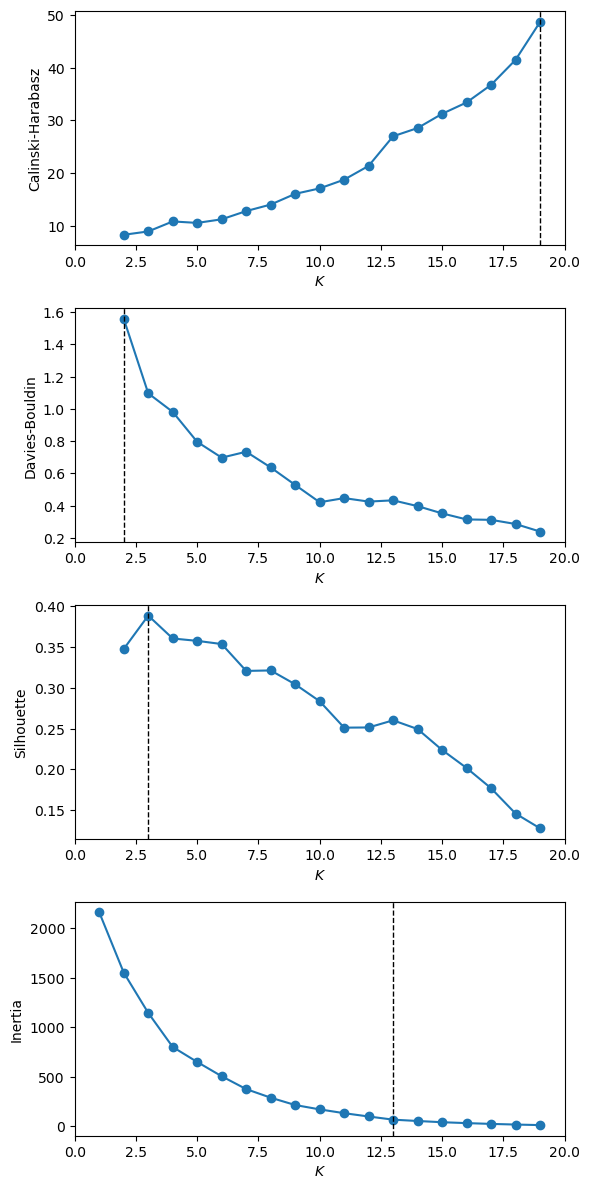

In [42]:
features_df = esp_df[X_name]
kmax = 20
cluster_method = "Agglomerate"  #"Kmeans"
plotYN = 'y'
index_vs_K_df,KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall = ESPClust.Clustering_indices(features_df,kmax,cluster_method,plotYN)

##### Outputs of `Clustering_indices`

- If `plotYN = "Y"`, the function `Clustering_indices` provides a plot for each of the clustering measures as a function of the number of clusters. A vertical dashed line indicates the optimal number of clusters for each of the measures.

- `Clustering_indices` provides a dataframe with the value of the clustering measures as a function of the number of clusters:

In [46]:
index_vs_K_df

,k,CH,DB,Sil,inertia
0,1,NaN,NaN,NaN,2162.000000
1,2,8.251839,1.558806,0.347529,1552.107540
2,3,8.886238,1.096565,0.388413,1144.748879
3,4,10.785948,0.981359,0.360361,799.838883
4,5,10.507195,0.795375,0.357465,648.289040
5,6,11.190757,0.697446,0.353558,503.798397
6,7,12.753284,0.734178,0.320648,373.887918
7,8,13.991778,0.636861,0.321243,287.137405
8,9,16.026780,0.528353,0.304288,212.833815
9,10,17.062747,0.420893,0.283560,168.739212


- `Clustering_indices` also gives the optimal value of the number of clusters according to each of the clustering measures and the overall optimal:

In [48]:
KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall

(19, 2, 3, 13, 2)

#### Principal component visualisation of the clusters in the effect size space

The clustering of effect size windows can be visualised with `ESP_pca` using principal component analysis. The required inputs are:

* `features_df`: Dataframe with the features (effect size profile) used to describe each element (window) to be clustered.
*  `cluster_method` ("Agglomerate" or "Kmeans"): Clustering method.
* `plotYN` (Y/N): If set to "Y", a plot for each of the clustering measures as a function of the number of clusters is displayed.
* `pcomp_1`: Integer giving the first principal component.
* `pcomp_2`: Integer giving the second principal component.
* `n_clusters`: Number of clusters. Windows within different clusters are represented with different colours.
* `clusterOrder`:  The order of clusters is arbitrary. This variable accepts a list of integers giving the label we wish for each cluster.


In [50]:
features_df = esp_df[X_name] 
n_clusters = koptimal_overall # Number of clusters to be coloured differently
clusterOrder = [0,1] # Try [1,0] to see the difference
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
pcomp_1=1 
pcomp_2=2
plotYN = "y"

x_pca,cumVar = ESPClust.ESP_pca(features_df,cluster_method,plotYN,pcomp_1,pcomp_2,n_clusters,clusterOrder)

ValueError: n_components=94 must be between 0 and min(n_samples, n_features)=23 with svd_solver='full'

##### Outputs

* If `plotYN = "y"`, a plot of the window lusters in the space spanned by the two selected principal components.
* `x_pca`: Coordinates of the projection of each feature on the principal component directions. 
* `cumVar`: array giving the cumulative explained variance for the principal components.

In [ ]:
x_pca

In [ ]:
cumVar

#### Cluster label of each window

The function `Window_clusters_labels` finds clusters and assign a label to each cluster. It returns the cluster label for each window.

In [ ]:
#------------------------------------
## ---- Labels of window clusters
#------------------------------------
n_clusters = koptimal_overall
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
features_df = esp_df[X_name]
labels = ESPClust.Window_clusters_labels(features_df,n_clusters,cluster_method,clusterOrder)
labels

#### Plot of the clusters in the covariate space

In [ ]:
n_clusters = koptimal_overall
clusterOrder=[0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
#%matplotlib widget
%matplotlib inline
labelsDF = ESPClust.plot_clusters_CovSpace(esp_df,X_name,modifier_names,n_clusters,cluster_method,clusterOrder)

#### Cluster centroids

The coordinates of the centroids of the clusters, their dispersion and inertia of the clustering are provided by the function `Window_cluster_centroids`.

In [ ]:
features_df = esp_df[X_name]
n_clusters = koptimal_overall
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"

plot = 'errorbar' #'errorbar' #'none' #'lines', 'points', 'points-lines' #'errorbar'
scale_ErrorSD = 1.96
diff_sorted = "Y"

centroids,centroids_SD,inertia = ESPClust.Window_cluster_centroids(features_df,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)

##### Outputs of `Window_cluster_centroids`

In [ ]:
centroids

In [ ]:
centroids_SD

In [ ]:
inertia

## ESPClust for three possible effect size profile modifiers

This section applies ESPClust to study BMI, sex and gene richness as a potential modifiers for the effect size profile corresponding to the association of the metabolites and insulin resistance.

### Defining the necessary variables for ESPClust

We first need to set the basic information needed by ESPClust in terms of exposures, outcome and covariates used as confounders and effect size mofifiers. Since sex will be considered as an effect size modifiers, ESPClust will stratify it and therefore no adjustement for sex is needed within strata.

In [93]:
data = featuresExtended  # Data containing the exposures, the outcome and the covariates
X_name = exposure_names  # Name of the exposures after cleaning
Y_name = "outcome" # Name of the outcome in the data 
modifier_names = ['BMI','sex','Gene richness']  # List of covariates to be considered as potential ESP modifiers
confound_names = ['BMI','Gene richness']  # List of covariates that act as confounders. Their confounding effect will be adjusted within each window of the cover.

### Creating a cover for the covariate space with windows of homogeneous size

We will cover the one-dimensional covariate space with a set of 1D-windows of length `L` obtained by gliding a segment at steps of size `Delta`. For a generic covariate $z$, the cover is following set of intervals: 

$\{ [z_{\min}, z_{\min}+L), [z_{\min}+Delta, z_{\min}+Delta+L), [z_{\min}+2Delta, z_{\min}+2Delta+L) \dots\}$, 

where $z_{\min}$ is the minimum value of the $z$ covariate in the dataset.

This can be implemented with the ESPClust function `Homogeneous_Windows`.

In [99]:
L_in = [8,0.5,0.2e6]  # A list of window lengths for each effect size modifier considered
Delta_in = [1,1,0.05e6]  # A list of the steps used to glide the window in the direction of each effect size modifier

z0,Lw = ESPClust.Homogeneous_Windows(data,modifier_names,L_in,Delta_in)

The function `Homogeneous_Windows` provides two outputs:
- `z0`: List of coordinates of the origin of each window, $\{ z_{min}, z_{min}+Delta, z_{min}+2Delta, \dots\}$. 
- `Lw`: List of dimensions of each window, $\{L,L,L,\dots\}$.

In [101]:
z0

[[18.1,
  19.1,
  20.1,
  21.1,
  22.1,
  23.1,
  24.1,
  25.1,
  26.1,
  27.1,
  28.1,
  29.1,
  30.1,
  31.1,
  32.1,
  33.1,
  34.1,
  35.1,
  36.1,
  37.1,
  38.1,
  39.1,
  40.1,
  41.1,
  42.1,
  43.1,
  44.1,
  45.1,
  46.1],
 [0, 1],
 [237605.0,
  287605.0,
  337605.0,
  387605.0,
  437605.0,
  487605.0,
  537605.0,
  587605.0,
  637605.0,
  687605.0,
  737605.0,
  787605.0,
  837605.0,
  887605.0,
  937605.0,
  987605.0,
  1037605.0]]

In [103]:
Lw

[[8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8],
 [0.5, 0.5],
 [200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0,
  200000.0]]

### Calculation of the ESP within windows

We use the ESPClust function `effect_windows3_lin` to use linear regression with three effect modifiers


In [108]:
nmin = 10  # Minimum number of observations required to calculate the effect size.

esp_df = ESPClust.effect_windows3_lin(data,X_name,Y_name,confound_names,modifier_names,z0,Lw,nmin)

Variable 1 of 94, M_6_2.4.Dihydroxybutanoic.acid.
Variable 2 of 94, M_27_2.Hydroxybutyric.acid
Variable 3 of 94, M_22_3.4.Dihydroxybutanoic.acid
Variable 4 of 94, M_25_3.Hydroxybutyric.acid
Variable 5 of 94, M_28_Alanine
Variable 6 of 94, M_30_Arachidonic.acid
Variable 7 of 94, M_8_Aspartic.acid
Variable 8 of 94, M_19_Cholesterol
Variable 9 of 94, M_9_Citric.acid
Variable 10 of 94, M_2_Glutamic.acid..3TMS
Variable 11 of 94, M_21_Glyceric.acid
Variable 12 of 94, M_10_Glycine
Variable 13 of 94, M_26_Isoleucine
Variable 14 of 94, M_23_Leucine
Variable 15 of 94, M_14_Linoleic.acid
Variable 16 of 94, M_4_Methionine
Variable 17 of 94, M_13_Oleic.acid
Variable 18 of 94, M_1_Ornithine
Variable 19 of 94, M_11_Palmitic.acid
Variable 20 of 94, M_3_Phenylalanine
Variable 21 of 94, M_12_Proline
Variable 22 of 94, M_24_Serine
Variable 23 of 94, M_17_Stearic.acid
Variable 24 of 94, M_5_Threonine
Variable 25 of 94, M_16_Tyrosine
Variable 26 of 94, M_20_Valine
Variable 27 of 94, M_212_11.Eicosenoic.aci

The funtion `effect_windows1_lin` provides the following dataframe:

`esp_df`: A dataframe with a row for each window of the cover used to sample the covariate space. For a given window, the datagrame gives the following columns:
* `nobs`: Number of observations within the window.
* `BMI_z0`: Origin of the window.
* `BMI_Lw`: Length of the window.
* $M$ columns giving the effect sizes $\{e_m\}_{m=1}^M$ within the window for each metabolite.


In [110]:
esp_df

,nobs,BMI_z0,BMI_Lw,sex_z0,sex_Lw,Gene richness_z0,Gene richness_Lw,M_6_2.4.Dihydroxybutanoic.acid.,M_27_2.Hydroxybutyric.acid,M_22_3.4.Dihydroxybutanoic.acid,...,M_191_Pyruvic.acid,M_65_Ribonic.acid,M_932_Ribonic.acid,M_123_Tryptophan,M_71_Tyrosine,M_1035_Urea,M_938_Xylitol,M_250_alpha.Hydroxyvaleric.acid,M_43_beta.D.Galactofuranose,M_298_beta.Hydroxyisovaleric.acid
0,11,18.1,8,0,0.5,487605.0,200000.0,0.429544,0.002823,0.124377,...,0.350142,-0.033106,0.406188,0.214013,0.086507,-0.170292,0.041404,0.450725,-0.466882,-0.061689
1,11,18.1,8,0,0.5,537605.0,200000.0,0.309348,0.066335,0.199606,...,0.263271,0.037248,0.312421,0.282744,0.035844,-0.100614,-0.057926,0.301533,-0.448903,0.072447
2,18,18.1,8,0,0.5,587605.0,200000.0,0.168499,0.026889,0.081000,...,0.225724,0.014909,0.065359,0.108038,-0.009213,-0.153364,-0.007231,0.001350,-0.387724,0.043602
3,20,18.1,8,0,0.5,637605.0,200000.0,0.152665,0.144637,0.150787,...,0.132742,0.098826,-0.084130,0.021748,-0.006295,-0.154314,-0.075410,-0.190062,-0.219918,-0.003659
4,23,18.1,8,0,0.5,687605.0,200000.0,0.046924,0.202069,0.134258,...,0.009760,0.164637,-0.017477,0.038289,0.041461,0.000150,0.022563,-0.238069,0.121622,0.121613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,14,35.1,8,1,0.5,737605.0,200000.0,0.211080,0.500362,0.745197,...,0.489499,0.141223,0.298953,0.474861,0.852144,0.807684,0.313694,-0.384562,0.495177,-0.590167
298,13,36.1,8,1,0.5,587605.0,200000.0,-0.237015,0.532568,0.568444,...,0.093868,0.213468,0.323378,-0.005090,0.640532,-0.321693,0.308317,-0.316637,0.372032,-0.268643
299,15,36.1,8,1,0.5,637605.0,200000.0,0.496441,0.411002,0.543845,...,0.336695,0.036228,0.319422,0.083948,0.639602,0.583727,0.386992,-0.322447,0.448966,0.013938
300,16,36.1,8,1,0.5,687605.0,200000.0,0.144289,0.404860,0.587312,...,0.439270,0.113128,0.459177,0.351275,0.769827,0.592591,0.182975,-0.353129,0.453519,-0.175784


It may be convenient to store the dataframe `esp_df` to be used in the future without the need to run the function `effect_windows1_lin`:

In [112]:
esp_df.to_csv('Results/EPS_IR_Metabolites_Modifiers_BMI_n10_LBMI_8_DeltaBMI_1_Lgr_0c2_Deltagr_0c05.csv')

**Reading previously calculated effect sizes:**

In [114]:
# - Read the data

esp_df = pd.read_csv('Results/EPS_IR_Metabolites_Modifiers_BMI_n10_LBMI_8_DeltaBMI_1_Lgr_0c2_Deltagr_0c05.csv')

### Visualisation of the windows effect size

The dependence of the effect size of the association between an exposure (`variable`) and the outcome as a function of a covariate (`modifier`) can be plotted with the function `Eff_size_Windows_plot` 

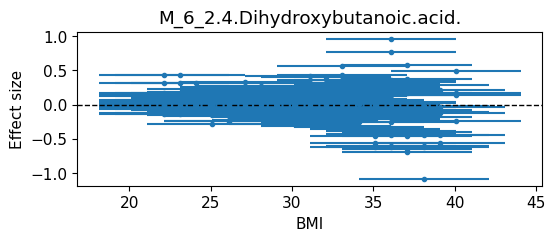

In [116]:
variable = X_name[0]
modifier = "BMI"
no_effect_value = 0
errorbar = 'y'
ESPClust.Eff_size_Windows_plot(esp_df,variable,modifier,no_effect_value,errorbar)

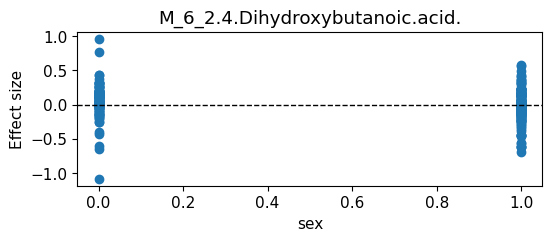

In [120]:
variable = X_name[0]
modifier = "sex"
no_effect_value = 0
errorbar = 'n'
ESPClust.Eff_size_Windows_plot(esp_df,variable,modifier,no_effect_value,errorbar)

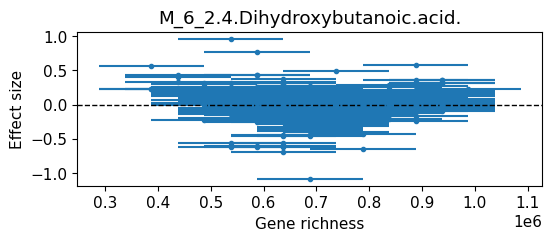

In [122]:
variable = X_name[0]
modifier = "Gene richness"
no_effect_value = 0
errorbar = 'y'
ESPClust.Eff_size_Windows_plot(esp_df,variable,modifier,no_effect_value,errorbar)

### Clustering of windows according to their ESP

ESPClust provides several functions to analyse the clustering of windows

#### Clustering indices

The function `Clustering_indices` four clustering measures as a function of the number of clusters ($k \in \{2,3,\dots,k_{\max}\}$): Calinski-Harabasz, Davies-Bouldin, silhouette and inertia. 

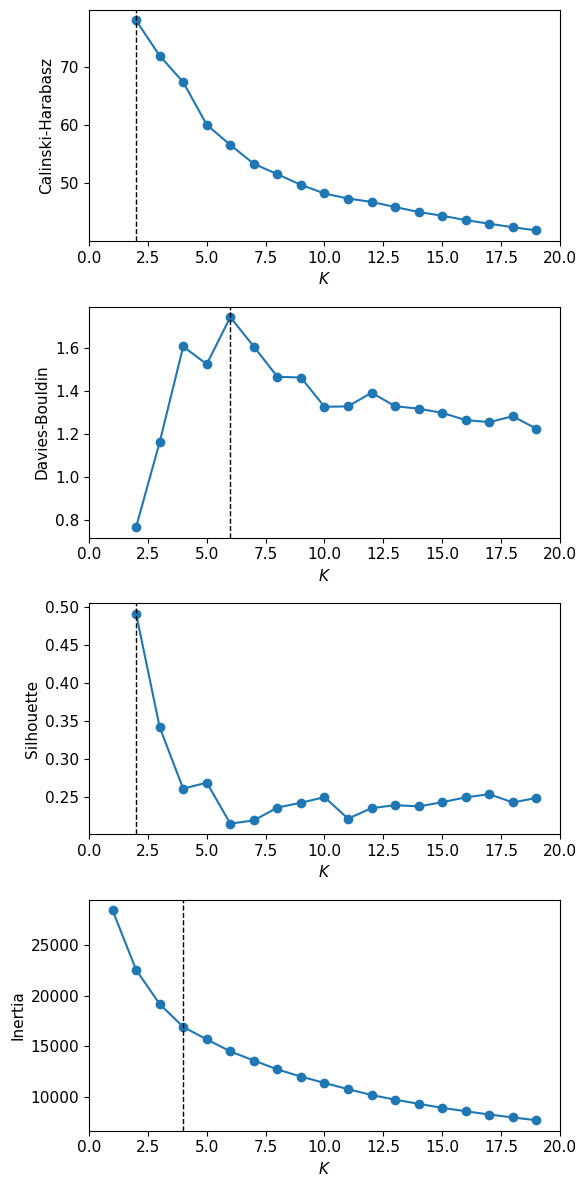

In [124]:
features_df = esp_df[X_name]
kmax = 20
cluster_method = "Agglomerate"  #"Kmeans"
plotYN = 'y'
index_vs_K_df,KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall = ESPClust.Clustering_indices(features_df,kmax,cluster_method,plotYN)

##### Outputs of `Clustering_indices`

- If `plotYN = "Y"`, the function `Clustering_indices` provides a plot for each of the clustering measures as a function of the number of clusters. A vertical dashed line indicates the optimal number of clusters for each of the measures.

- `Clustering_indices` provides a dataframe with the value of the clustering measures as a function of the number of clusters:

In [126]:
index_vs_K_df

,k,CH,DB,Sil,inertia
0,1,NaN,NaN,NaN,28388.000000
1,2,77.987178,0.767274,0.490875,22530.923004
2,3,71.925685,1.162520,0.342059,19166.728591
3,4,67.392954,1.607954,0.261291,16913.197785
4,5,60.053592,1.525373,0.269422,15694.360562
5,6,56.613201,1.744850,0.215594,14511.036572
6,7,53.354140,1.607353,0.219806,13614.244538
7,8,51.571627,1.467010,0.236657,12742.067610
8,9,49.742448,1.463489,0.242969,12038.221898
9,10,48.263368,1.327100,0.250290,11411.942143


- `Clustering_indices` also gives the optimal value of the number of clusters according to each of the clustering measures and the overall optimal:

In [129]:
KoptimalCH,KoptimalDB,KoptimalSil,KoptimalElbow,koptimal_overall

(2, 6, 2, 4, 2)

#### Principal component visualisation of the clusters in the effect size space

The clustering of effect size windows can be visualised with `ESP_pca` using principal component analysis. The required inputs are:

* `features_df`: Dataframe with the features (effect size profile) used to describe each element (window) to be clustered.
*  `cluster_method` ("Agglomerate" or "Kmeans"): Clustering method.
* `plotYN` (Y/N): If set to "Y", a plot for each of the clustering measures as a function of the number of clusters is displayed.
* `pcomp_1`: Integer giving the first principal component.
* `pcomp_2`: Integer giving the second principal component.
* `n_clusters`: Number of clusters. Windows within different clusters are represented with different colours.
* `clusterOrder`:  The order of clusters is arbitrary. This variable accepts a list of integers giving the label we wish for each cluster.


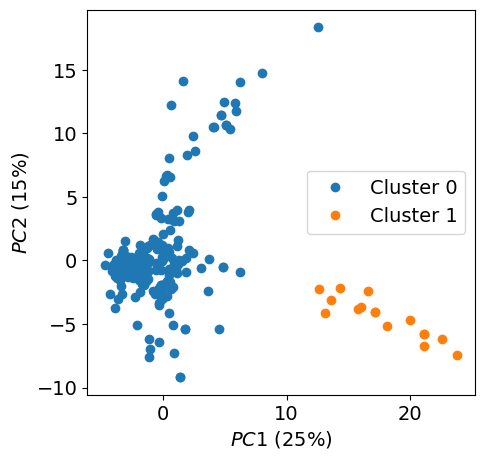

In [141]:
features_df = esp_df[X_name] 
n_clusters = koptimal_overall # Number of clusters to be coloured differently
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
pcomp_1=1 
pcomp_2=2
plotYN = "y"

x_pca,cumVar = ESPClust.ESP_pca(features_df,cluster_method,plotYN,pcomp_1,pcomp_2,n_clusters,clusterOrder)

##### Outputs

* If `plotYN = "y"`, a plot of the window lusters in the space spanned by the two selected principal components.
* `x_pca`: Coordinates of the projection of each feature on the principal component directions. 
* `cumVar`: array giving the cumulative explained variance for the principal components.

In [143]:
x_pca

array([[-3.43771973e+00, -5.57164747e-01, -2.40299219e+00, ...,
         1.34927552e-02,  5.11860536e-02, -4.38927807e-02],
       [-3.28695616e+00,  7.96135791e-01, -2.66773359e+00, ...,
        -1.87765845e-02, -3.75717783e-02,  7.94194052e-03],
       [-3.68367988e+00, -7.52315736e-01, -2.29091174e+00, ...,
         2.44271362e-02, -2.72622029e-02, -6.50040489e-03],
       ...,
       [ 1.19125644e+00,  1.64832148e+00,  8.36687555e+00, ...,
        -2.81879176e-02, -6.15824522e-03, -8.52160068e-02],
       [ 1.04879783e+00, -6.99884827e-01,  8.25888892e+00, ...,
         6.58341768e-03, -5.08274173e-02,  3.31773289e-02],
       [ 2.42182744e+00,  5.76711643e-01,  9.53202277e+00, ...,
        -1.10838271e-02,  7.04029723e-02, -4.45634595e-02]])

In [145]:
cumVar

array([0.25299886, 0.40414931, 0.50478671, 0.57710878, 0.63512107,
       0.68071183, 0.71428448, 0.74714691, 0.77303851, 0.79448897,
       0.81332124, 0.83087704, 0.84469787, 0.85749493, 0.8699987 ,
       0.88130374, 0.89160369, 0.90038294, 0.90807042, 0.91545389,
       0.92137705, 0.92700508, 0.93249997, 0.93701153, 0.94128086,
       0.94535163, 0.94921186, 0.95276853, 0.95595252, 0.95882877,
       0.96149414, 0.96405426, 0.96641628, 0.96867595, 0.9707062 ,
       0.97258986, 0.97433335, 0.97589729, 0.97742332, 0.97889372,
       0.98017859, 0.98139865, 0.98257807, 0.98362459, 0.98464433,
       0.98561445, 0.98653016, 0.98733962, 0.9881183 , 0.98889143,
       0.9896312 , 0.99028161, 0.99087508, 0.99145071, 0.99202179,
       0.99255714, 0.99306178, 0.9935537 , 0.99397831, 0.99438409,
       0.99477762, 0.99514716, 0.99550196, 0.99583192, 0.99615032,
       0.99642911, 0.99669849, 0.99695779, 0.99719182, 0.99741886,
       0.99764158, 0.99784873, 0.99804463, 0.99823745, 0.99841

#### Cluster label of each window

The function `Window_clusters_labels` finds clusters and assign a label to each cluster. It returns the cluster label for each window.

In [147]:
#------------------------------------
## ---- Labels of window clusters
#------------------------------------
n_clusters = koptimal_overall
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
features_df = esp_df[X_name]
labels = ESPClust.Window_clusters_labels(features_df,n_clusters,cluster_method,clusterOrder)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Plot of the clusters in the covariate space

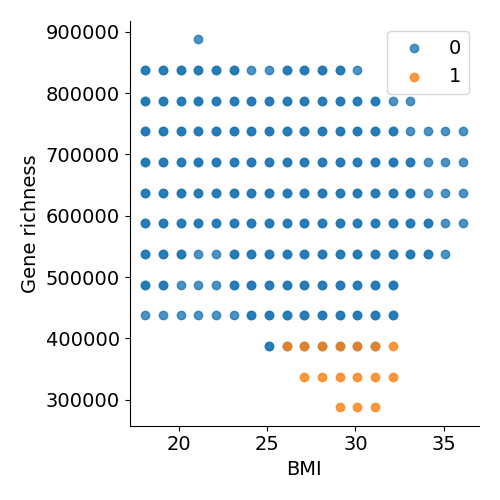

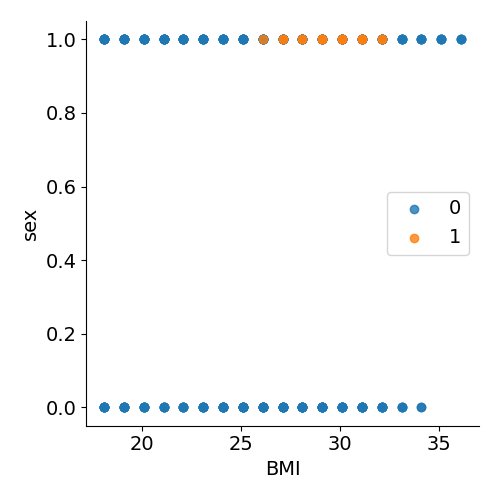

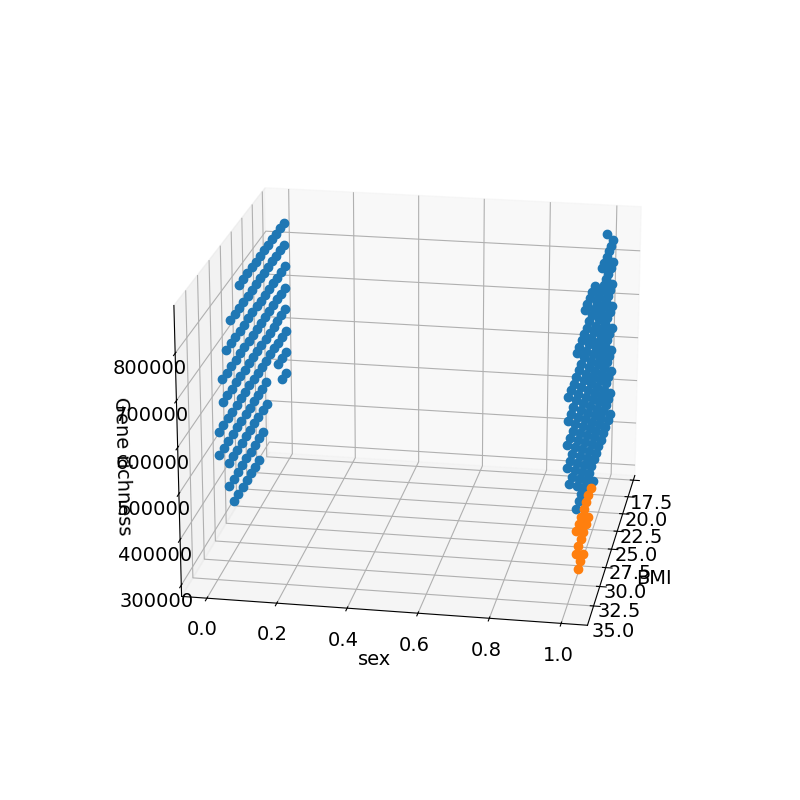

In [151]:
n_clusters = koptimal_overall
clusterOrder=[0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"
%matplotlib widget
#%matplotlib inline
labelsDF = ESPClust.plot_clusters_CovSpace(esp_df,X_name,modifier_names,n_clusters,cluster_method,clusterOrder)

In [153]:
%matplotlib inline

#### Cluster centroids

The coordinates of the centroids of the clusters, their dispersion and inertia of the clustering are provided by the function `Window_cluster_centroids`.

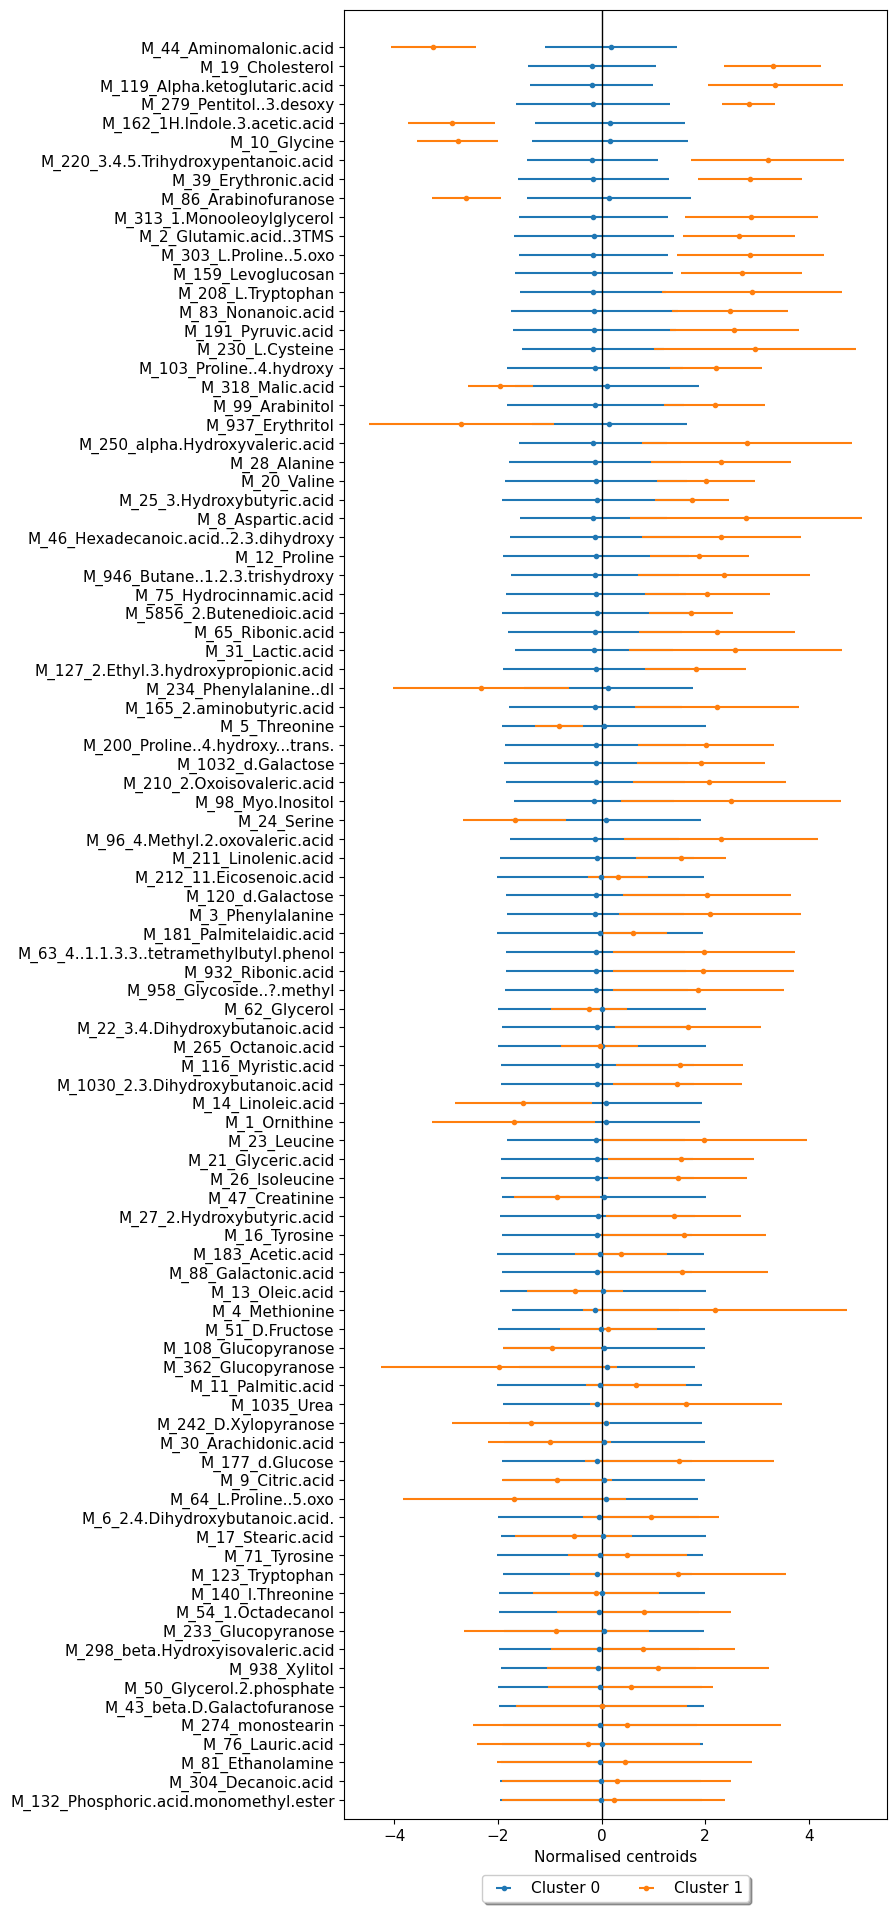

In [157]:
features_df = esp_df[X_name]
n_clusters = koptimal_overall
clusterOrder = [0,1]
cluster_method = "Agglomerate" #"Kmeans" #"Agglomerate"

plot = 'errorbar' #'errorbar' #'none' #'lines', 'points', 'points-lines' #'errorbar'
scale_ErrorSD = 1.96
diff_sorted = "Y"

centroids,centroids_SD,inertia = ESPClust.Window_cluster_centroids(features_df,n_clusters,cluster_method,clusterOrder,plot,scale_ErrorSD,diff_sorted)

##### Outputs of `Window_cluster_centroids`

In [159]:
centroids

,M_132_Phosphoric.acid.monomethyl.ester,M_304_Decanoic.acid,M_81_Ethanolamine,M_76_Lauric.acid,M_274_monostearin,M_43_beta.D.Galactofuranose,M_50_Glycerol.2.phosphate,M_938_Xylitol,M_298_beta.Hydroxyisovaleric.acid,M_233_Glucopyranose,...,M_313_1.Monooleoylglycerol,M_86_Arabinofuranose,M_39_Erythronic.acid,M_220_3.4.5.Trihydroxypentanoic.acid,M_10_Glycine,M_162_1H.Indole.3.acetic.acid,M_279_Pentitol..3.desoxy,M_119_Alpha.ketoglutaric.acid,M_19_Cholesterol,M_44_Aminomalonic.acid
0,-0.013097,-0.016141,-0.024925,0.014498,-0.027314,0.000028,-0.031370,-0.060708,-0.045050,0.048741,...,-0.161414,0.145972,-0.160455,-0.179563,0.155444,0.162003,-0.158823,-0.187684,-0.184579,0.181534
1,0.234100,0.288512,0.445535,-0.259145,0.488240,-0.000502,0.560741,1.085150,0.805277,-0.871246,...,2.885278,-2.609241,2.868134,3.209681,-2.778562,-2.895801,2.838967,3.354856,3.299345,-3.244921


In [161]:
centroids_SD

,M_132_Phosphoric.acid.monomethyl.ester,M_304_Decanoic.acid,M_81_Ethanolamine,M_76_Lauric.acid,M_274_monostearin,M_43_beta.D.Galactofuranose,M_50_Glycerol.2.phosphate,M_938_Xylitol,M_298_beta.Hydroxyisovaleric.acid,M_233_Glucopyranose,...,M_313_1.Monooleoylglycerol,M_86_Arabinofuranose,M_39_Erythronic.acid,M_220_3.4.5.Trihydroxypentanoic.acid,M_10_Glycine,M_162_1H.Indole.3.acetic.acid,M_279_Pentitol..3.desoxy,M_119_Alpha.ketoglutaric.acid,M_19_Cholesterol,M_44_Aminomalonic.acid
0,0.992507,0.989861,0.977612,0.992223,0.955776,1.008267,1.000186,0.959104,0.985679,0.982282,...,0.734963,0.804606,0.745088,0.644603,0.768827,0.741806,0.758903,0.605171,0.632691,0.651104
1,1.099546,1.128154,1.257705,1.098197,1.514705,0.838589,0.813226,1.090286,0.907505,0.909004,...,0.654897,0.337445,0.514949,0.754527,0.396040,0.428987,0.263729,0.666249,0.474362,0.422572


In [163]:
inertia

22530.9230037716

### Effect size profile in groups representing two clusters

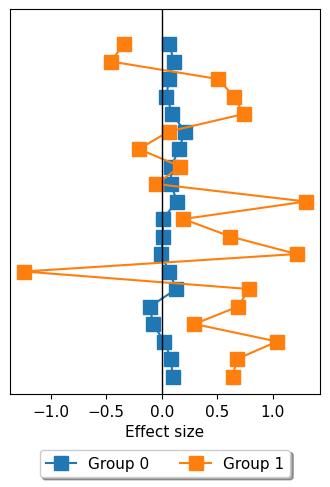

In [182]:
# set the BMI and gene richness limits to define the groups (Group 1: BMI>26 and Gene richness < 450000)
BMI_l = 26
Generichness_h = 450000

# Sort the exposures from largest to smallest overlap between the two groups
sorted_total_overlap, index_sorted_total_overlap = ESPClust.total_overlap(centroids,centroids_SD,scale_ErrorSD)

distance2 = features_df[features_df.columns[index_sorted_total_overlap]]
#centres2,centres_SD2,inertia2 = Window_cluster_centres_aux(distance2,n_clusters,cluster_method,scale_ErrorSD,plot,clusterOrder)


X_name2 = distance2.columns #distance2.columns[-npanels:][::-1]
X_name_temp = X_name2[-20:]

alphasig = 1 #0.05
plot_yn = "y"

EffSize_clust_df_list = []
clust_index = []

# - Cluster of high gene richness and low BMI
c = 0
clust_index.append(c)

data_c = data.loc[~((data["BMI"] >= BMI_l) & (data["Gene richness"] <= Generichness_h))]

dataX = data_c[X_name_temp]
dataY = data_c["outcome"]

confounderIn=data_c[confound_names]
pvtlr,siglr, pvalBHlr, sigBH0lr, beta, ciL, ciH = ESPClust.LinSignificance(dataX,dataY,confounderIn,alphasig,'n')

dforsorted = pd.DataFrame({"met_name": siglr, "beta": beta, "ciL": ciL, "ciH": ciH})

EffSize_clust_df_list.append(dforsorted)

# - Cluster of low gene richness and high BMI
c = 1
clust_index.append(c)

data_c = data.loc[((data["BMI"] >= BMI_l) & (data["Gene richness"] <= Generichness_h))]

dataX = data_c[X_name_temp]
dataY = data_c["outcome"]

confounderIn=data_c[confound_names]
pvtlr,siglr, pvalBHlr, sigBH0lr, beta, ciL, ciH = ESPClust.LinSignificance(dataX,dataY,confounderIn,alphasig,'n')

dforsorted = pd.DataFrame({"met_name": siglr, "beta": beta, "ciL": ciL, "ciH": ciH})

EffSize_clust_df_list.append(dforsorted)

fig_width = 4
if (plotYN == 'Y') | (plotYN == 'y'):
    font = {'size'   : 11}
    plt.rc('font', **font)

    verticalD = max([4.,len(X_name_temp)/4.])
    fig, ax = plt.subplots(figsize=(fig_width, verticalD))

    #centres = kmeans.cluster_centers_

    #ax.hlines(metsgroup,centres[0],np.zeros(len(centres[0])),colors='y')
    #ax.hlines(metsgroup,centres[1],np.zeros(len(centres[0])),colors='b')
    for i in range(len(EffSize_clust_df_list)):
            ax.plot(EffSize_clust_df_list[i]["beta"],X_name_temp,'-s',label='Group '+str(clust_index[i]),markersize=10)
            #ax.plot(EffSize_clust_df_list[i]["beta"],X_name_temp,'s',label='Group '+str(clust_index[i]),markersize=10)
            #ax.errorbar(EffSize_clust_df_list[i]["beta"],X_name_temp,xerr=[EffSize_clust_df_list[i]["ciL"],EffSize_clust_df_list[i]["ciH"]],fmt='.',label='Group '+str(i))
        
    ax.axvline(x = 0, color = 'black', ls='-', lw=1)
    ax.set_xlabel('Effect size')
    ax.set_ylim([-1,len(X_name_temp)+1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -2.5/len(X_name_temp)),fancybox=True, shadow=True, ncol=5)

    # disabling yticks by setting yticks to an empty list
    ax.set_yticks([])  

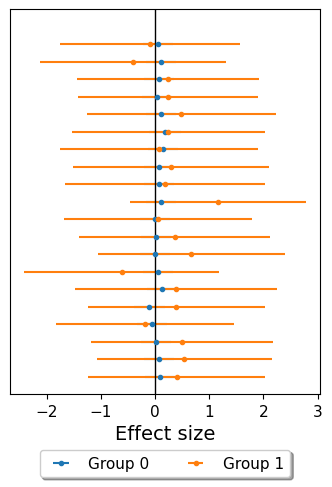

In [186]:
BMI_l = 26
Generichness_h = 480000

# Sort the exposures from largest to smallest overlap between the two groups
sorted_total_overlap, index_sorted_total_overlap = ESPClust.total_overlap(centroids,centroids_SD,scale_ErrorSD)

distance2 = features_df[features_df.columns[index_sorted_total_overlap]]
#centres2,centres_SD2,inertia2 = Window_cluster_centres_aux(distance2,n_clusters,cluster_method,scale_ErrorSD,plot,clusterOrder)


X_name2 = X_name2 = distance2.columns #distance2.columns[-npanels:][::-1]
X_name_temp = X_name2[-20:]

alphasig = 1 #0.05
plot_yn = "y"

EffSize_clust_df_list = []
clust_index = []

# - Cluster of high gene richness and low BMI
c = 0
clust_index.append(c)

data_c = data.loc[~((data["BMI"] >= BMI_l) & (data["Gene richness"] <= Generichness_h))]

dataX = data_c[X_name_temp]
dataY = data_c["outcome"]

confounderIn=data_c[confound_names]
pvtlr,siglr, pvalBHlr, sigBH0lr, beta, ciL, ciH = ESPClust.LinSignificance(dataX,dataY,confounderIn,alphasig,'n')

dforsorted = pd.DataFrame({"met_name": siglr, "beta": beta, "ciL": ciL, "ciH": ciH})

EffSize_clust_df_list.append(dforsorted)

# - Cluster of low gene richness and high BMI
c = 1
clust_index.append(c)

data_c = data.loc[((data["BMI"] >= BMI_l) & (data["Gene richness"] <= Generichness_h))]

dataX = data_c[X_name_temp]
dataY = data_c["outcome"]

confounderIn=data_c[confound_names]
pvtlr,siglr, pvalBHlr, sigBH0lr, beta, ciL, ciH = ESPClust.LinSignificance(dataX,dataY,confounderIn,alphasig,'n')

dforsorted = pd.DataFrame({"met_name": siglr, "beta": beta, "ciL": ciL, "ciH": ciH})

EffSize_clust_df_list.append(dforsorted)

fig_width = 4
if (plotYN == 'Y') | (plotYN == 'y'):
    font = {'size'   : 11}
    plt.rc('font', **font)

    verticalD = max([4.,len(X_name_temp)/4.])
    fig, ax = plt.subplots(figsize=(fig_width, verticalD))

    #centres = kmeans.cluster_centers_

    #ax.hlines(metsgroup,centres[0],np.zeros(len(centres[0])),colors='y')
    #ax.hlines(metsgroup,centres[1],np.zeros(len(centres[0])),colors='b')
    for i in range(len(EffSize_clust_df_list)):
            #ax.plot(EffSize_clust_df_list[i]["beta"],X_name_temp,'-s',label='Group '+str(clust_index[i]),markersize=10)
            #ax.plot(EffSize_clust_df_list[i]["beta"],X_name_temp,'s',label='Group '+str(clust_index[i]),markersize=10)
            ax.errorbar(EffSize_clust_df_list[i]["beta"],X_name_temp,xerr=[EffSize_clust_df_list[i]["ciL"],EffSize_clust_df_list[i]["ciH"]],fmt='.',label='Group '+str(i))
        
    ax.axvline(x = 0, color = 'black', ls='-', lw=1)
    ax.set_xlabel('Effect size', fontsize=14)
    ax.set_ylim([-1,len(X_name_temp)+1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -2.5/len(X_name_temp)),fancybox=True, shadow=True, ncol=5)

    # disabling yticks by setting yticks to an empty list
    ax.set_yticks([])  